<a href="https://colab.research.google.com/github/ikapil06/Natural-language-processing/blob/main/BERTFinetuning_Spam_Ham_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('/content/spamdata_v2.csv')

In [3]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.describe()

,label
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
lens=[len(i.split()) for i in df.text]

(array([3.599e+03, 1.772e+03, 1.390e+02, 3.800e+01, 1.200e+01, 6.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.,  18.,  35.,  52.,  69.,  86., 103., 120., 137., 154., 171.]),
 <BarContainer object of 10 artists>)

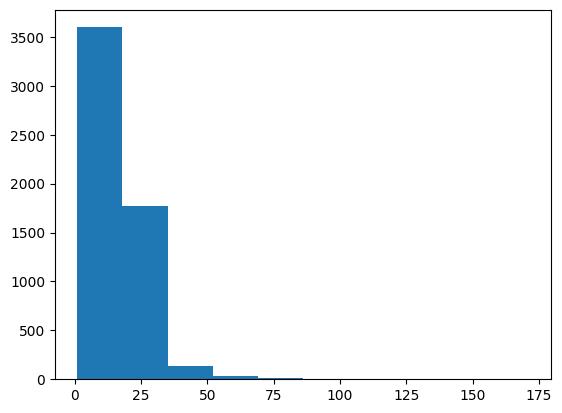

In [6]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [7]:
!pip install transformers

In [8]:
#for pytorch
import torch
import torch.nn as nn
device = torch.device("cuda")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast

In [9]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [11]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([2.525e+03, 1.235e+03, 9.600e+01, 2.500e+01, 9.000e+00, 4.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.,  18.,  35.,  52.,  69.,  86., 103., 120., 137., 154., 171.]),
 <BarContainer object of 10 artists>)

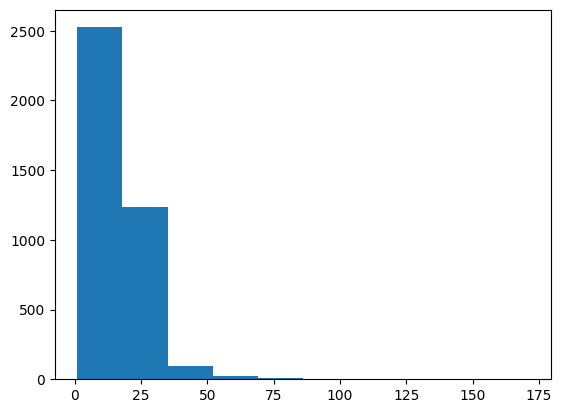

In [12]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

As per the above graph, as most of the texts are having around 17 words, we would consider 17 as the padding length.

In [13]:
pad_len=25

In [14]:
# tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [17]:
# freeze the BERT architecture

for param in bert.parameters():
    param.requires_grad = False

Below, we define the BERT architecture, i.e., define our own layers in addition to the actual BERT architecture

In [18]:
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [19]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

# push the model to GPU
model = model.to(device)

In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)  # learning rate

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

class weights are [0.57743559 3.72848948] for [0 1]


In [22]:
#count of both the categories of training labels
pd.value_counts(train_labels)

0    3377
1     523
Name: label, dtype: int64

In [23]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [24]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [26]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.6772627449426495
Validation Loss: 0.6597847129617419

 Epoch 2 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.657643729546031
Validation Loss: 0.6406307859080178

 Epoch 3 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.6402259469032288
Validation Loss: 0.6222902706691197

 Epoch 4 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.6244682259246951
Validation Loss: 0.6071078947612217

 Epoch 5 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.6074274504770998
Validation Loss: 0.589567461184093

 Epoch 6 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.5967885031074774
Validation Loss: 0.5740449258259365

 Epoch 7 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.5823736151710885
Validation Loss: 0.5617190578154155

 Epoch 8 / 10
  Batch    50  of     61.

Evaluating...

Training Loss: 0.567146761495559
Validation Loss: 0.5453

In [27]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
from sklearn.metrics import classification_report

In [30]:
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.99      0.82      0.89       724
           1       0.44      0.92      0.59       112

    accuracy                           0.83       836
   macro avg       0.71      0.87      0.74       836
weighted avg       0.91      0.83      0.85       836

